In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn.functional as F
from jupyterplot import ProgressPlot
import torch.nn as nn
import copy
import time
from itertools import count
import math
from agent.utils import EpisodeStats

/media/external/grassy_lab/KAN/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#KAN

from agent.lstm import KanLSTM
from fastkan import FastKAN as KAN

class ADRQNKAN(nn.Module):
    def __init__(self, n_actions, state_size, embedding_size):
        super(ADRQNKAN, self).__init__()
        self.n_actions = n_actions
        self.embedding_size = embedding_size
        self.embedder = KAN([n_actions, embedding_size], num_grids=5)
        # self.embedder = nn.Linear(n_actions, embedding_size)
        self.obs_layer = KAN([state_size, 16], num_grids=5)
        # self.obs_layer = nn.Linear(state_size, 16)
        self.obs_layer2 = KAN([16, 32], num_grids=5)
        # self.obs_layer2 = nn.Linear(16,32)
        self.lstm = KanLSTM(input_size = 32+embedding_size, hidden_size = 128, num_outputs=128)
        self.out_layer = KAN([128, n_actions], num_grids=5)
        # self.out_layer = nn.Linear(128, n_actions)
    
    def forward(self, observation, action, hidden = None):
        #Takes observations with shape (batch_size, seq_len, obs_dim)
        #Takes one_hot actions with shape (batch_size, seq_len, n_actions)
        action_embedded = self.embedder(action)
        observation = F.relu(self.obs_layer(observation))
        observation = F.relu(self.obs_layer2(observation))
        lstm_input = torch.cat([observation, action_embedded], dim = -1)
        if hidden is not None:
            lstm_out, hidden_out = self.lstm(lstm_input, hidden)
        else:
            lstm_out, hidden_out = self.lstm(lstm_input)

        q_values = self.out_layer(lstm_out)
        return q_values, hidden_out
    
    def act(self, observation, last_action, epsilon, hidden = None):
        q_values, hidden_out = self.forward(observation, last_action, hidden)
        if np.random.uniform() > epsilon:
            action = torch.argmax(q_values).item()
        else:
            action = np.random.randint(self.n_actions)
        return action, hidden_out


In [3]:
class ADRQN(nn.Module):
    def __init__(self, n_actions, state_size, embedding_size):
        super(ADRQN, self).__init__()
        self.n_actions = n_actions
        self.embedding_size = embedding_size
        self.embedder = nn.Linear(n_actions, embedding_size)
        self.obs_layer = nn.Linear(state_size, 16)
        self.obs_layer2 = nn.Linear(16,32)
        self.lstm = nn.LSTM(input_size = 32+embedding_size, hidden_size = 128, batch_first = True)
        self.out_layer = nn.Linear(128, n_actions)
    
    def forward(self, observation, action, hidden = None):
        #Takes observations with shape (batch_size, seq_len, obs_dim)
        #Takes one_hot actions with shape (batch_size, seq_len, n_actions)
        action_embedded = self.embedder(action)
        observation = F.relu(self.obs_layer(observation))
        observation = F.relu(self.obs_layer2(observation))
        lstm_input = torch.cat([observation, action_embedded], dim = -1)
        if hidden is not None:
            lstm_out, hidden_out = self.lstm(lstm_input, hidden)
        else:
            lstm_out, hidden_out = self.lstm(lstm_input)

        q_values = self.out_layer(lstm_out)
        return q_values, hidden_out
    
    def act(self, observation, last_action, epsilon, hidden = None):
        q_values, hidden_out = self.forward(observation, last_action, hidden)
        if np.random.uniform() > epsilon:
            action = torch.argmax(q_values).item()
        else:
            action = np.random.randint(self.n_actions)
        return action, hidden_out

In [4]:
from agent.utils import EpisodeStats, initialize_env_settings, Evaluation

def run_episode(
    env, agent, observation, last_action, epsilon, rendering=False, max_timesteps=200, in_distribution_range=0.0, out_distribution_range=0):
    """
    This methods runs one episode for a gym environment.
    """
    stats = EpisodeStats()
    initialize_env_settings(env, percentage_range=in_distribution_range, out_of_distribution_percentage_range=out_distribution_range)
    observation = env.reset()

    step = 0
    while True:
        action_id, hidden = agent.act(torch.tensor(observation).float().view(1,1,-1).to(device),F.one_hot(torch.tensor(last_action), n_actions).view(1,1,-1).float().to(device), hidden = None, epsilon = epsilon)
        next_state, reward, terminal, info = env.step(action_id)
        stats.step(reward, action_id)

        observation = next_state
        last_action = action_id

        if rendering:
            env.render()

        if terminal or step > max_timesteps:
            break

        step += 1

    return stats

In [5]:
class ExpBuffer():
    def __init__(self, max_storage, sample_length):
        self.max_storage = max_storage
        self.sample_length = sample_length
        self.counter = -1
        self.filled = -1
        self.storage = [0 for i in range(max_storage)]

    def write_tuple(self, aoarod):
        if self.counter < self.max_storage-1:
            self.counter +=1
        if self.filled < self.max_storage:
            self.filled += 1
        else:
            self.counter = 0
        self.storage[self.counter] = aoarod
    
    def sample(self, batch_size):
        #Returns sizes of (batch_size, seq_len, *) depending on action/observation/return/done
        seq_len = self.sample_length
        last_actions = []
        last_observations = []
        actions = []
        rewards = []
        observations = []
        dones = []

        for i in range(batch_size):
            if self.filled - seq_len < 0 :
                raise Exception("Reduce seq_len or increase exploration at start.")
            start_idx = np.random.randint(self.filled-seq_len)
            #print(self.filled)
            #print(start_idx)
            last_act, last_obs, act, rew, obs, done = zip(*self.storage[start_idx:start_idx+seq_len])
            last_actions.append(list(last_act))
            last_observations.append(last_obs)
            actions.append(list(act))
            rewards.append(list(rew))
            observations.append(list(obs))
            dones.append(list(done))
           
        return torch.tensor(last_actions).to(device), torch.tensor(last_observations, dtype = torch.float32).to(device), torch.tensor(actions).to(device), torch.tensor(rewards).float().to(device) , torch.tensor(observations, dtype = torch.float32).to(device), torch.tensor(dones).to(device)

cuda:0
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished
... finished


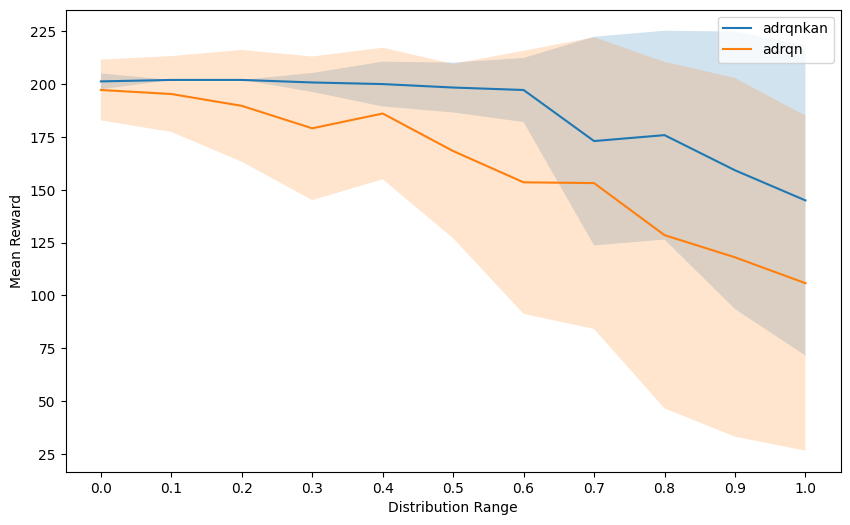

In [6]:
import os
from datetime import datetime
import json
import numpy as np
import gym
import matplotlib.pyplot as plt

np.random.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
env = gym.make('CartPole-v1').unwrapped
state_size = env.observation_space.shape[0]
n_actions = env.action_space.n
embedding_size = 8
distribution_ranges = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n_test_episodes = 30

plt.figure(figsize=(10, 6))

for agent_type in ['adrqnkan', 'adrqn']:
    if agent_type == 'adrqn':
        agent = ADRQN(n_actions, state_size, embedding_size).to(device)
        agent.load_state_dict(torch.load('./models_adrqn/adrqn_cartpole_best.pth'))
    else:
        agent = ADRQNKAN(n_actions, state_size, embedding_size).to(device)
        agent.load_state_dict(torch.load('./models_adrqn/adrqnkan_cartpole_best.pth'))

    last_action = 0
    observation = env.reset()

    means = []
    stds = []

    for distribution_range in distribution_ranges:
        episode_rewards = []
        for i in range(n_test_episodes):
            stats = run_episode(
                env, agent, observation, last_action, 0,  rendering=False, max_timesteps=200, 
                in_distribution_range=distribution_range
            )
            episode_rewards.append(stats.episode_reward)

        # save results in a dictionary and write them into a .json file
        results = dict()
        results["episode_rewards"] = episode_rewards
        results["mean"] = np.array(episode_rewards).mean()
        results["std"] = np.array(episode_rewards).std()

        means.append(results["mean"])
        stds.append(results["std"])

        env.close()
        print("... finished")

    plt.plot(distribution_ranges, means, label=agent_type)
    plt.fill_between(distribution_ranges, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2)

plt.xlabel("Distribution Range")
plt.xticks(distribution_ranges)
plt.ylabel("Mean Reward")
plt.legend()
plt.show()